# Exploration 16. 다음에 볼 영화 예측하기 🔮🔮🔮

## Step 0. 데이터 불러오기

In [1]:
# 주요 라이브러리 불러오기
import pandas
import tensorflow
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
# 1) 데이터 확인
# $ ls -l ~/data

# 2) 프로젝트 폴더 생성
# $ mkdir -p ~/aiffel/yoochoose

# 3) 프로젝트 폴더로 데이터 폴더 링크 연결
# $ ln -s ~/data/* ~/aiffel/yoochoose/data

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True) # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### Rating 3 미만인 데이터 제거
- User가 선호하지 않는 영화라고 판단

In [4]:
data = data[data['Rating'] >= 3]

## 🪄 데이터 EDA 
- SessionID 대신 UserID 항목이 들어갑니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않기 때문에 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있으므로 고려해야 합니다. Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

## Step 1. 데이터의 전처리
- 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### (1)  유저수(세션 수)와 아이템 수 확인하기
> #### 🪄 추천시스템을 구축할 때 가장 먼저 확인해 볼 것 !! 

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

Rating 3 미만인 영화 제거 전
- 유저 수: 6040명, 아이템 수: 3706개
Rating 3 미만인 영화 제거 후
- 유저 수: 6040명, 아이템 수: 3408개

In [6]:
duplicate = data.duplicated(subset=['UserId'])
duplicate

31         False
22          True
27          True
37          True
24          True
           ...  
1000019     True
999988      True
1000172     True
1000167     True
1000042     True
Length: 836478, dtype: bool

In [7]:
(duplicate==True).count()

836478

### (2) Session Length
- 각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.

In [8]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [9]:
session_length.median(), session_length.mean()

(81.0, 138.51266766020865)

In [10]:
session_length.min(), session_length.max()

(1, 1968)

In [11]:
session_length.quantile(0.999)

1118.8860000000013

각 유저마다 세션의 길이는 보통 80~135로 나옵니다. 
99.9% 세션은 길이가 1119 이하입니다.  
길이가 1968인 세션은 뭔가 이상하므로 살펴보겠습니다.

In [12]:
long_session = session_length[session_length==1968].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697055,4169,3207,3,1024172606
695958,4169,3413,3,1024173191
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760


- 너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있으나, 99% 세션과 엄청나게 큰 차이는 아니므로 이상치가 아니라고 판단하여 포함시켰습니다.

### 🪄  시각화하기
 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화

In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

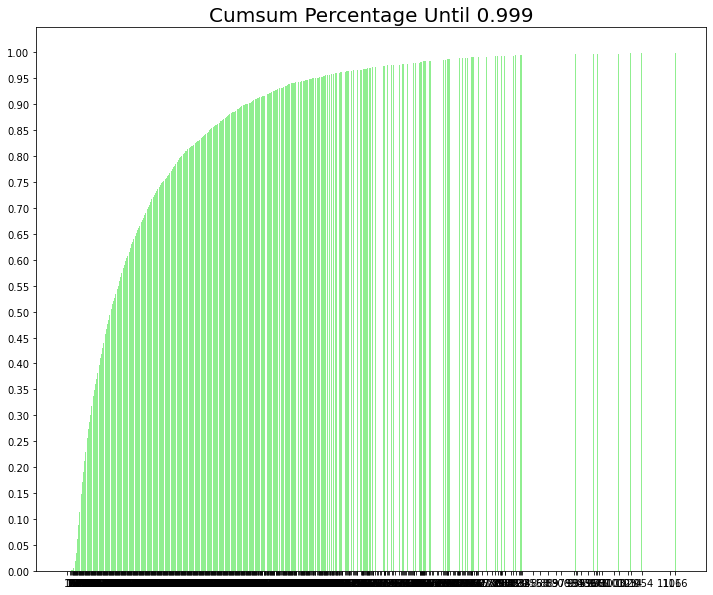

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='lightgreen')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### (3) Session Time
- 유저들의 소비 패턴을 금방금방 변합니다.
- 이런 이유 때문에 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.

> ### 🪄 추천 시스템에서 다루는 시간 관련 데이터
데이터 생성 날짜, 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등

#### 데이터의 시간 관련 정보 확인하기

In [15]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [16]:
from datetime import datetime

datetime = []
for time in data['Time']:
    timestamp = dt.datetime.utcfromtimestamp(time)
    datetime.append(timestamp)

In [17]:
data['Datetime'] = datetime
data['Datetime']

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Datetime, Length: 836478, dtype: datetime64[ns]

In [18]:
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [19]:
oldest, latest = data['Datetime'].min(), data['Datetime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [20]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [21]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

### (4) Data Cleansing
- 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해 줍니다.
- 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해 줍니다.

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
data = cleanse_recursive(data, shortest = 2, least_click = 5)
data

,UserId,ItemId,Rating,Time,Datetime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


### ✨ 학습에 사용할 데이터
- User: 최소 두 편 이상의 영화를 시청한 유저
- Item: 최소한 다섯 번 이상 시청된 영화

### 한 유저ID가 몇 개의 영화에 평점 데이터를 남겼는지 확인

In [24]:
user_length = data.groupby('UserId').size() 

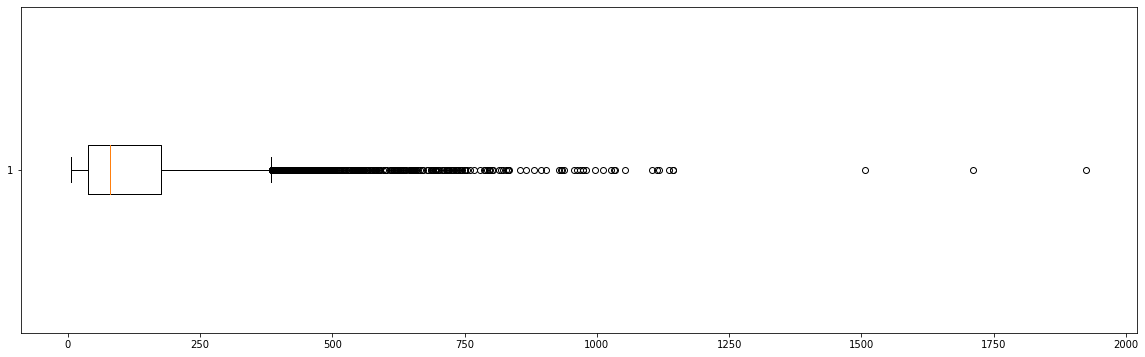

In [25]:
plt.figure(figsize=(20,6))
plt.boxplot(user_length, vert=0)
plt.show()

## Step 2. 미니 배치의 구성
- 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### (1) Train / Valid / Test으로 나누기

In [26]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Datetime'].max()
    user_in_train = data[data['Datetime'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Datetime'] >= final_time - dt.timedelta(n_days)]

    return user_in_train, user_in_test

In [27]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [28]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

#### test, valid 데이터: 6개월(180일)치로 지정합니다.

In [29]:
tr, test = split_by_date(data, 180)
tr, val = split_by_date(tr, 180)

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 818736
	 Users: 6036
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9771
	 Users: 390
	 Items: 2348
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7282
	 Users: 333
	 Items: 2049
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



#### train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.

In [31]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

#### 데이터 저장하기

In [32]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### (2) Data Pipeline

### 🪄 Session Dataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.user_offsets = self.get_user_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())

    def get_user_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        
        return offsets

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


### ✨ 인스턴스 변수 살펴보기
`user_offsets`: User의 시작 인덱스를 담고 있습니다.  
`user_idx` : 각 User를 인덱싱한 np.array 입니다.



In [35]:
tr_dataset.user_offsets

array([     0,     53,    169, ..., 818341, 818460, 818736], dtype=int32)

In [36]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

### (3) SessionDataLoader

In [37]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1
        start = self.dataset.user_offsets[self.dataset.user_idx[first_iters]]
        end = self.dataset.user_offsets[self.dataset.user_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.user_idx[-1]:
                finished = True
                break

            start[idx] = self.dataset.user_offsets[self.dataset.user_idx[new_session]]
            end[idx] = self.dataset.user_offsets[self.dataset.user_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [38]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = iter(tr_data_loader)

In [39]:
tr_dataset.df

,UserId,ItemId,Rating,Time,Datetime,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,1104
999988,6040,1921,4,997454464,2001-08-10 14:41:04,315
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,87
1000167,6040,161,3,997454486,2001-08-10 14:41:26,410


In [40]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성
실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

> ### 🪄 Evaluation Metric
>- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋습니다.
>- recall의 개념을 확장한 `recall@k`, precision의 개념을 확장한 `Mean Average Precision@k`를 사용합니다.
>- 추천 시스템에서는 몇 번째로 맞추느냐도 중요하기 때문에 순서에 민감한 지표인 `MRR`, `NDCG`도 사용합니다.

### (1) MRR과 Recall@k 사용하기
- `MRR`은 정답 아이템이 나온 순번의 역수 값  
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고, 
뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### (2) Model Architecture

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    
    return model

#### 모델에 사용할 hyper-parameter를 class형식으로 관리하기

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [45]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    503850    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [46]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [47]:
train_model(model, args)

Evaluation:  14%|█▍        | 5/36 [00:07<00:43,  1.41s/it]


	 - Recall@20 epoch 1: 0.058594
	 - MRR@20    epoch 1: 0.014659



Evaluation:  14%|█▍        | 5/36 [00:06<00:40,  1.29s/it]


	 - Recall@20 epoch 2: 0.086719
	 - MRR@20    epoch 2: 0.021650



Evaluation:  14%|█▍        | 5/36 [00:06<00:39,  1.27s/it]


	 - Recall@20 epoch 3: 0.095312
	 - MRR@20    epoch 3: 0.027283



Evaluation:  14%|█▍        | 5/36 [00:07<00:43,  1.41s/it]


	 - Recall@20 epoch 4: 0.102344
	 - MRR@20    epoch 4: 0.030365



Evaluation:  14%|█▍        | 5/36 [00:06<00:40,  1.31s/it]


	 - Recall@20 epoch 5: 0.106250
	 - MRR@20    epoch 5: 0.035826



Evaluation:  14%|█▍        | 5/36 [00:06<00:42,  1.36s/it]


	 - Recall@20 epoch 6: 0.110937
	 - MRR@20    epoch 6: 0.035440



Evaluation:  14%|█▍        | 5/36 [00:06<00:40,  1.31s/it]


	 - Recall@20 epoch 7: 0.110937
	 - MRR@20    epoch 7: 0.035125



Evaluation:  14%|█▍        | 5/36 [00:06<00:39,  1.27s/it]


	 - Recall@20 epoch 8: 0.114844
	 - MRR@20    epoch 8: 0.036013



Evaluation:  14%|█▍        | 5/36 [00:06<00:38,  1.25s/it]


	 - Recall@20 epoch 9: 0.114844
	 - MRR@20    epoch 9: 0.036309



Evaluation:  14%|█▍        | 5/36 [00:06<00:39,  1.27s/it]

	 - Recall@20 epoch 10: 0.115625
	 - MRR@20    epoch 10: 0.034767



## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### 1. Hyperparameter: Model 1 
- batch_size=256
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=10

In [48]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:33,  1.32s/it]

	 - Recall@20: 0.115234
	 - MRR@20: 0.037348



## 🔮🔮🔮 하이퍼파라미터 변경
### 2. Model 2
- batch_size=128
- hsz=100
- drop_rate=0.25
- lr=0.001
- epochs=5

In [49]:
args2 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1022700   
_________________________________________________________________
dropout_1 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (128, 3307)               334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


Evaluation:  47%|████▋     | 34/73 [00:24<00:27,  1.41it/s]


	 - Recall@20 epoch 1: 0.107077
	 - MRR@20    epoch 1: 0.029420



Evaluation:  47%|████▋     | 34/73 [00:23<00:26,  1.47it/s]


	 - Recall@20 epoch 2: 0.129596
	 - MRR@20    epoch 2: 0.036381



Evaluation:  47%|████▋     | 34/73 [00:23<00:26,  1.48it/s]


	 - Recall@20 epoch 3: 0.131893
	 - MRR@20    epoch 3: 0.038380



Evaluation:  47%|████▋     | 34/73 [00:22<00:25,  1.53it/s]


	 - Recall@20 epoch 4: 0.139936
	 - MRR@20    epoch 4: 0.040316



Evaluation:  47%|████▋     | 34/73 [00:22<00:25,  1.53it/s]

	 - Recall@20 epoch 5: 0.137868
	 - MRR@20    epoch 5: 0.039991



In [50]:
test_model(model2, args2, test)

Evaluation:  37%|███▋      | 20/54 [00:13<00:22,  1.49it/s]

	 - Recall@20: 0.151172
	 - MRR@20: 0.044413



### 3. Model 3
- batch_size=64
- hsz=100
- drop_rate=0.4
- lr=0.001
- epochs=5

In [51]:
args3 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.4, lr=0.001, epochs=5, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1022700   
_________________________________________________________________
dropout_2 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (64, 3307)                334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]


	 - Recall@20 epoch 1: 0.115179
	 - MRR@20    epoch 1: 0.031248



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.80it/s]


	 - Recall@20 epoch 2: 0.131845
	 - MRR@20    epoch 2: 0.037277



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.79it/s]


	 - Recall@20 epoch 3: 0.136756
	 - MRR@20    epoch 3: 0.037720



Evaluation:  72%|███████▏  | 105/146 [00:37<00:14,  2.78it/s]


	 - Recall@20 epoch 4: 0.141667
	 - MRR@20    epoch 4: 0.040765



Evaluation:  72%|███████▏  | 105/146 [00:38<00:15,  2.71it/s]

	 - Recall@20 epoch 5: 0.141071
	 - MRR@20    epoch 5: 0.040609



In [52]:
test_model(model3, args3, test)

Evaluation:  59%|█████▉    | 64/108 [00:22<00:15,  2.83it/s]

	 - Recall@20: 0.162109
	 - MRR@20: 0.047961



### 4. Model 4
- batch_size=256
- hsz=50
- drop_rate=0.2
- lr=0.001
- epochs=10

In [53]:
args4 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    503850    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  14%|█▍        | 5/36 [00:07<00:46,  1.50s/it]


	 - Recall@20 epoch 1: 0.065625
	 - MRR@20    epoch 1: 0.014790



Evaluation:  14%|█▍        | 5/36 [00:06<00:41,  1.35s/it]


	 - Recall@20 epoch 2: 0.091406
	 - MRR@20    epoch 2: 0.025873



Evaluation:  14%|█▍        | 5/36 [00:06<00:40,  1.29s/it]


	 - Recall@20 epoch 3: 0.108594
	 - MRR@20    epoch 3: 0.030634



Evaluation:  14%|█▍        | 5/36 [00:06<00:41,  1.35s/it]


	 - Recall@20 epoch 4: 0.108594
	 - MRR@20    epoch 4: 0.032822



Evaluation:  14%|█▍        | 5/36 [00:06<00:39,  1.26s/it]


	 - Recall@20 epoch 5: 0.108594
	 - MRR@20    epoch 5: 0.032855



Evaluation:  14%|█▍        | 5/36 [00:06<00:41,  1.33s/it]


	 - Recall@20 epoch 6: 0.114844
	 - MRR@20    epoch 6: 0.035382



Evaluation:  14%|█▍        | 5/36 [00:06<00:39,  1.29s/it]


	 - Recall@20 epoch 7: 0.118750
	 - MRR@20    epoch 7: 0.034910



Evaluation:  14%|█▍        | 5/36 [00:06<00:40,  1.31s/it]


	 - Recall@20 epoch 8: 0.121094
	 - MRR@20    epoch 8: 0.036110



Evaluation:  14%|█▍        | 5/36 [00:06<00:41,  1.33s/it]


	 - Recall@20 epoch 9: 0.125000
	 - MRR@20    epoch 9: 0.036956



Evaluation:  14%|█▍        | 5/36 [00:06<00:39,  1.28s/it]

	 - Recall@20 epoch 10: 0.121875
	 - MRR@20    epoch 10: 0.036953



In [54]:
test_model(model4, args4, test)

Evaluation:   7%|▋         | 2/27 [00:02<00:32,  1.28s/it]

	 - Recall@20: 0.105469
	 - MRR@20: 0.041303



## 🪄 결과 

- 4개의 조합으로 모델을 돌렸을 때, Model3가 제일 괜찮게 나온 것 같다.
- 각 성능지표가 의미하는 바를 정확히 알지는 못해서 판단하기도 애매하고, 애초에 성능지표를 무엇으로 쓰느냐와 하이퍼파라미터의 조합에 따라 결과가 달라질 것이다.

## 회고 🔮🔮🔮

1. 유저 수에서 중복데이터가 생각보다 많이 나와서 어떻게 이해하고 처리할지 고민이 되었다. 고민하고 찾아보고 다른 분들과 얘기해본 결과 한 `UserId`를 여러 명이 동시에 사용할 수도 있기 때문에 그럴 수도 있겠다는 생각이 들었다. 처음 데이터를 접하고 이를 이해하는데 시간이 좀 걸렸다.


2. `datetime` 모듈을 사용하는 법을 제대로 배울 수 있어서 좋았다. 일반 숫자를 날짜 데이터로 바꿔주는 모듈을 활용하니 데이터 전처리가 훨씬 편리해지는 것을 볼 수 있었다. 앞으로 더 많은 모듈들이 생겨나서 코딩 1~2줄이면 모든 데이터를 전처리할 수 있게되는 미래가 그려진다. 기술의 빠른 변화에 발 맞춰 나 스스로도 도태되지 않도록 열심히 공부하고 알아봐야겠다. 


3. 모델을 구성하는 건 실습 노드에 코드가 자세히 나와 별다른 어려움을 느끼진 않았지만, 아무 것도 없이 저렇게 코드를 구현하기에는 아직 부족한 실력인 것 같다. 코드 한 줄 한 줄 따라치면서 성실하게 복습해야겠다. 


4. 하이퍼 파라미터 변경은 언제나 귀찮은 일이다... ㅎ 그래도 이제는 어디를 어떻게 바꿔야 하는지 감이 생겨서 전보다 시행착오의 범위가 줄어든 것이 감사하다. hsz는 뭔지 몰라서 구글링해본 결과 hue augmentation과 관련된 것이라고 하는데 아직 어떤 숫자가 좋은 건지에 대해서는 완전히 이해되진 않았다.


5. 아이펠 과정 중반부에 들어서니 조금은 해이해지는 것 같다... 다시금 의욕을 되찾고 뿜!뿜!해야겠다 👑